# Aidan Elliott

## Research question/interests

Most scientists agree that climate change has been significantly accelerated due to human expansion. The rate at which countries emmit C02 varies greatly due to population, gdp, etc. However, I want to explore whether the more carbon a country emits affects their increase in temperature locally greater than their global affect. We can get significant insight to this question by examining a dataset containing emission data by country over time with another dataset tracking average temperature by country over time.

# Importing my Datasets

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df_em = pd.read_csv("../data/raw/owid_emissions.csv") #Emissions dataframe
df_em.head(5)

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_cumulative_other_co2,share_global_flaring_co2,share_global_gas_co2,share_global_luc_co2,share_global_oil_co2,share_global_other_co2,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Afghanistan,1850,AFG,3752993.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.121,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1851,AFG,3769828.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.118,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1852,AFG,3787706.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.116,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1853,AFG,3806634.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.115,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1854,AFG,3825655.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.114,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_tp = pd.read_csv("../data/raw/GlobalLandTemperaturesByCountry.csv")
df_tp.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


# Cleaning Emissions Dataset

###### This dataset has many NaN values for years when data was tracked nicely. Because of this, I am getting rid of any data before the year 1930 and countries that have a population less than 30 million

In [ ]:
mydf = df_em.drop(df_em[df_em["year"] < 1960].index)
mydf = mydf.drop(mydf[mydf["population"] < 30000000].index)
mydf


,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_cumulative_other_co2,share_global_flaring_co2,share_global_gas_co2,share_global_luc_co2,share_global_oil_co2,share_global_other_co2,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
162,Afghanistan,2012,AFG,30466484.0,5.916690e+10,0.029,0.001,10.035,-1.803,-15.230,...,NaN,0.000,0.005,0.009,0.057,NaN,28.55,28.80,NaN,NaN
163,Afghanistan,2013,AFG,31541216.0,6.299370e+10,0.036,0.001,9.251,-0.785,-7.820,...,NaN,0.000,0.005,0.005,0.048,NaN,26.77,27.02,NaN,NaN
164,Afghanistan,2014,AFG,32716214.0,6.434611e+10,0.029,0.001,9.170,-0.080,-0.867,...,NaN,0.000,0.004,0.002,0.044,NaN,26.52,26.76,NaN,NaN
165,Afghanistan,2015,AFG,33753500.0,6.278339e+10,0.041,0.001,9.791,0.621,6.770,...,NaN,0.000,0.004,0.007,0.056,NaN,26.84,27.09,NaN,NaN
166,Afghanistan,2016,AFG,34636212.0,6.429743e+10,0.076,0.002,9.068,-0.723,-7.389,...,NaN,0.000,0.005,0.010,0.048,NaN,27.05,26.89,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46174,Yemen,2017,YEM,30034386.0,6.852740e+10,0.671,0.022,10.589,-0.313,-2.870,...,NaN,0.195,0.008,-0.033,0.067,NaN,23.84,23.84,NaN,NaN
46175,Yemen,2018,YEM,30790514.0,6.904272e+10,0.657,0.021,10.474,-0.114,-1.081,...,NaN,0.225,0.003,-0.036,0.068,NaN,23.86,23.86,NaN,NaN
46176,Yemen,2019,YEM,31546694.0,NaN,0.664,0.021,12.684,2.210,21.096,...,NaN,0.306,0.003,-0.033,0.082,NaN,25.26,25.26,NaN,NaN
46177,Yemen,2020,YEM,32284044.0,NaN,0.664,0.021,12.140,-0.544,-4.287,...,NaN,0.402,0.003,-0.038,0.084,NaN,NaN,NaN,NaN,NaN


## Column Selection

####       This dataset contains a massive amount of columns for us to examine. However, most of the columns provide data about where in the country co2 is being emitted from. While this is very insightful information, the scope of this project is more focused on total co2 emissions. Because of this, we are only going to keep the columns regarding the country, year, it's total co2 emissions from that year, and it's percentage growth from the previous year.

In [ ]:
mydf = mydf.iloc[:,[0,1,3,4,7,9]]
mydf

,country,year,population,gdp,co2,co2_growth_prct
162,Afghanistan,2012,30466484.0,5.916690e+10,10.035,-15.230
163,Afghanistan,2013,31541216.0,6.299370e+10,9.251,-7.820
164,Afghanistan,2014,32716214.0,6.434611e+10,9.170,-0.867
165,Afghanistan,2015,33753500.0,6.278339e+10,9.791,6.770
166,Afghanistan,2016,34636212.0,6.429743e+10,9.068,-7.389
...,...,...,...,...,...,...
46174,Yemen,2017,30034386.0,6.852740e+10,10.589,-2.870
46175,Yemen,2018,30790514.0,6.904272e+10,10.474,-1.081
46176,Yemen,2019,31546694.0,NaN,12.684,21.096
46177,Yemen,2020,32284044.0,NaN,12.140,-4.287


[Text(0, 0.5, 'CO2 emissions (millions of tons)')]

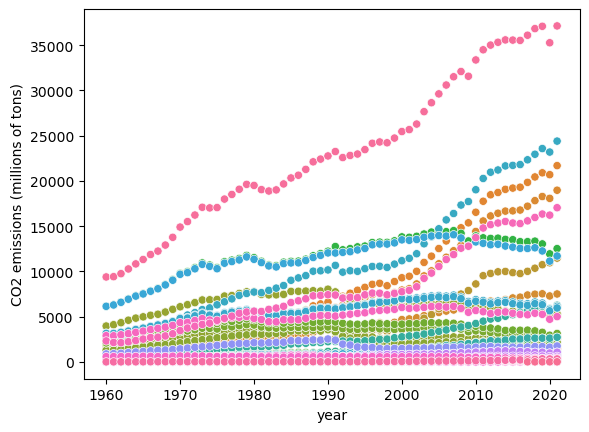

In [ ]:
import seaborn as sns
sns.scatterplot(data=mydf, x="year", y="co2", hue="country", legend=False).set(ylabel="CO2 emissions (millions of tons)")

### The above scatterplot is clearly not very useful to get any information out of. Let's get rid of any countries which do not have enough data from the past 62 years.

In [ ]:

num_datapoints = mydf["country"].value_counts().to_frame()
countries = num_datapoints.drop(num_datapoints[num_datapoints["country"] < 50].index) #List of all countries with data from more than 50 years.
mydf = mydf[mydf["country"].isin(countries.index.tolist())] #drop any rows from countries which do not have data from more than 50 years.

### To avoid the need of each group member cleaning the data, I am uploading this processed dataset to our repository

In [ ]:
mydf.to_csv("../data/processed/processedEmissoinsData.csv")

# Grouping Emissions Dataset

## The dataset already has aggregated values for CO2 emissions for continents and income brackets. Comparing the emissions of a continent with a country is not extremely useful so the next few lines will be grouping continents, large countries, and by income brackets. This "sub-datasets" will be saved for future analysis.

### Grouping Continents

<AxesSubplot:xlabel='year', ylabel='co2'>

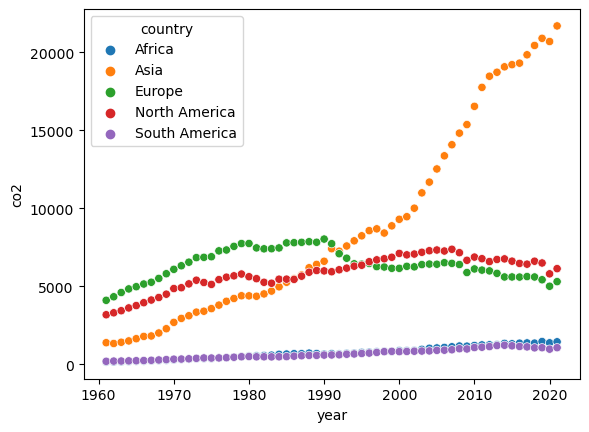

In [ ]:
continent_list = ["Africa","North America","Oceania", "South America", "Asia", "Europe"]
continents = mydf[mydf["country"].isin(continent_list)].reset_index()
sns.scatterplot(data=continents, x="year", y="co2", hue="country")

### Grouping some of the World's Largest Countries

<AxesSubplot:xlabel='year', ylabel='co2'>

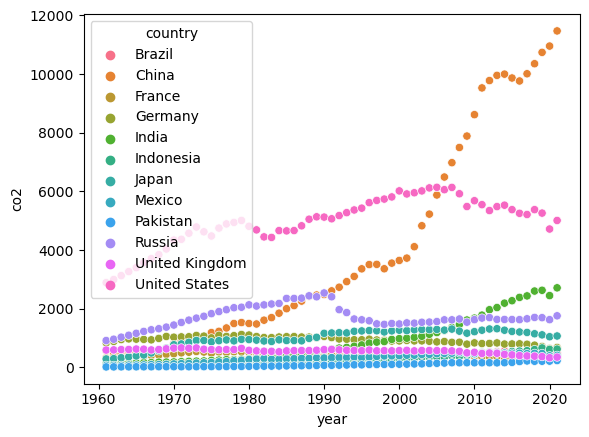

In [ ]:
largeCountryList = ["United States","Mexico","Russia","Pakistan","United Kingdom","Japan","Bangledesh","Brazil","China","India","Indonesia","France","Germany"]
largeCountries = mydf[mydf["country"].isin(largeCountryList)].reset_index()
sns.scatterplot(data=largeCountries, x="year", y="co2", hue="country")

### Income Bracket

<AxesSubplot:xlabel='year', ylabel='co2'>

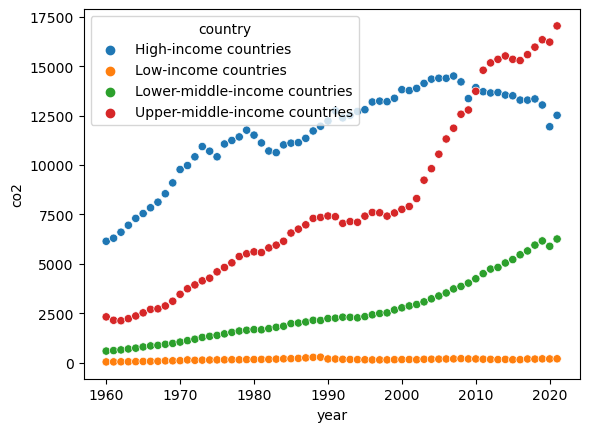

In [ ]:
incomeBasedList = ["Low-income countries","Lower-middle-income countries","Upper-middle-income countries","High-income countries"]
incomeBased = mydf[mydf["country"].isin(incomeBasedList)].reset_index()
sns.scatterplot(data=incomeBased, x="year", y="co2", hue="country")

# Cleaning Temperature Dataset

In [ ]:
df_tp.head(4)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland


### The dt column represents what months and year the AverageTemperature is from. The csv file imports this as a string. In order to do comparisons with it, we must convert it to a datetime object.

In [ ]:
df_tp["dt"] = (df_tp["dt"].apply(pd.to_datetime)).dt.date
type(df_tp.iloc[1,0])

datetime.date

### The average temperature of each month is not of interest for my research question. My goal is to convert the AverageTemperature column to a yearly average. The below cell turns all the datetime objects into just the year the data was taken from.

In [ ]:
df_tp["year"] = [x.year for x in df_tp["dt"]]
df_tp.head(4)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,year
0,1743-11-01,4.384,2.294,Åland,1743
1,1743-12-01,NaN,NaN,Åland,1743
2,1744-01-01,NaN,NaN,Åland,1744
3,1744-02-01,NaN,NaN,Åland,1744


### Now we can group the average temperature by year and country and collect the mean yearly temperature of each country then create a new dataframe from it.

In [ ]:
temp_df = df_tp.groupby([df_tp["year"],df_tp["Country"]])["AverageTemperature"].mean(numeric_only=True).reset_index() 
temp_df.head(4)

,year,Country,AverageTemperature
0,1743,Albania,8.620
1,1743,Andorra,7.556
2,1743,Austria,2.482
3,1743,Belarus,0.767


## For my teammates use, I'm going to save this datafile in the processed file on our remote repository

In [ ]:
temp_df.to_csv("../data/processed/processedTemperatureData.csv")

# Grouping Temperature Dataset

In [ ]:
canada = temp_df[temp_df["Country"]=="Canada"]

[(-10.0, 0.0)]

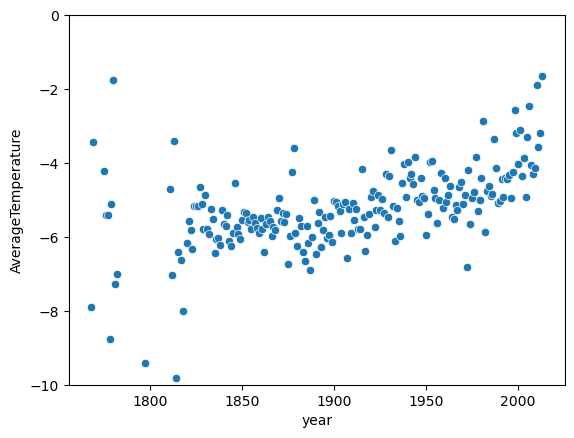

In [ ]:
sns.scatterplot(data=canada, y=canada["AverageTemperature"], x=canada["year"]).set(ylim=(-10,0))

# Using Geopandas to Plot Change in Temperature


### Since our data is geographical, being able to plot our data on a map is extremely useful. The Geopandas package is extremely useful for this exact purpose and will make our geographical plots much more sophisticated.

#### My goal for this visualization is to plot the change in average annual temperature from 1960-2013. For this, we must subtract the 1960 temp from the 2013 temp for every country, add it to the world GeoDataFrame and then plot it. Visualizing this will help us make some qualitative observations about whether certain countries are more affected by cO2 emissions than others.

In [ ]:
import geopandas
# world is our dataframe. The Geometry column is what allows us to plot the earth with such percision
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [ ]:
#Sorting our world and temperature dataframes alphabetically
sorted_world = world.sort_values(by=["name"])
sorted_temp = temp_df.sort_values(by=["Country","year"])
sorted_world.head(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
103,38041754.0,Asia,Afghanistan,AFG,19291,"POLYGON ((66.51861 37.36278, 67.07578 37.35614..."
125,2854191.0,Europe,Albania,ALB,15279,"POLYGON ((21.02004 40.84273, 20.99999 40.58000..."
82,43053054.0,Africa,Algeria,DZA,171091,"POLYGON ((-8.68440 27.39574, -8.66512 27.58948..."
74,31825295.0,Africa,Angola,AGO,88815,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
159,4490.0,Antarctica,Antarctica,ATA,898,"MULTIPOLYGON (((-48.66062 -78.04702, -48.15140..."


In [ ]:
# Some countries had different names in the dataframes so they initially showed up blank on the final graph.
# I manually searched for the differences and changed the temperature datafrme accordingly.
sorted_temp.replace({"United States":"United States of America",
                     "Congo (Democratic Republic Of The)" : "Dem. Rep. Congo",
                     "Central African Republic":"Central African Rep.",
                     "Côte D'Ivoire":"Côte d'Ivoire",
                     "Czech Republic":"Czechia"}, inplace=True)                   

### The temperature dataframe contains ~50 more smaller nations / regions than the world dataframe. We don't care about the nations that will not show up on the plot anyway so the following cell gets rid of any country's data not in the world dataframe. We also drop any data from before 1960.

In [ ]:
spliced_temp = sorted_temp[sorted_temp["Country"].isin(sorted_world["name"].unique().tolist())]
spliced_temp = spliced_temp[spliced_temp["year"] > 1959] #Drop any data from before 1960

### Now we must pivot our data so that the country names are the index, and the year as the row. This aids us in calculating our change in temperature for each country all at once

In [ ]:
pivoted_temp = spliced_temp.pivot(index="Country",columns=["year"],values=["AverageTemperature"])
pivoted_temp.head(5)

AverageTemperature                                              \
year                      1960       1961       1962       1963       1964   
Country                                                                      
Afghanistan          13.985417  14.064917  13.768667  15.033417  13.084917   
Albania              13.335083  13.316750  13.068750  13.085833  12.515333   
Algeria              23.504083  23.390333  23.182417  23.317833  23.147500   
Angola               21.927083  21.938750  21.848667  21.837750  21.686417   
Antarctica                 NaN        NaN        NaN        NaN        NaN   

                                                                    ...  \
year              1965       1966       1967       1968       1969  ...   
Country                                                             ...   
Afghanistan  14.101833  14.343000  13.663250  13.762333  13.805083  ...   
Albania      12.378417  13.204583  12.621750  12.869583  12.802917  ...   
Algeria      22.973750  23.301333  22.861667  23.185917  23.458250  ...   
Angola       21.819917  22.103250  21.776417  21.748167  22.190500  ...   
Antarctica         NaN        NaN        NaN        NaN        NaN  ...   

                                                                               \
year              2004       2005       2006       2007       2008       2009   
Country                                                                         
Afghanistan  15.770917  14.980000  15.595583  15.106167  15.216500  15.257750   
Albania      13.258167  12.747083  12.976917  13.890500  13.955167  13.844250   
Algeria      23.916000  24.222583  24.200833  24.065333  23.950250  24.154333   
Angola       22.572833  22.966083  21.947083  22.427083  22.287333  22.316500   
Antarctica         NaN        NaN        NaN        NaN        NaN        NaN   

                                                         
year              2010       2011       2012       2013  
Country                                                  
Afghanistan  15.828667  15.518000  14.481583  16.533625  
Albania      13.775417  13.443250  13.768250  14.993875  
Algeria      25.215667  24.144167  23.954833  25.121500  
Angola       22.681500  22.029667  22.123333  22.507875  
Antarctica         NaN        NaN        NaN        NaN  

[5 rows x 54 columns]

### Calculating delta_temp column by taking the difference between 2013 and 1960

#### Admittedly this is not the most accurate measurement of temperature change as 1960 could've been a cold year or 2013 could've been a hot year but it get's the point across for our exploratory analysis.

In [ ]:
pivoted_temp["delta_temp"] = pivoted_temp.iloc[:,53] - pivoted_temp.iloc[:,0]
pivoted_temp.head(2)

AverageTemperature                                              \
year                      1960       1961       1962       1963       1964   
Country                                                                      
Afghanistan          13.985417  14.064917  13.768667  15.033417  13.084917   
Albania              13.335083  13.316750  13.068750  13.085833  12.515333   

                                                                   ...  \
year              1965       1966      1967       1968       1969  ...   
Country                                                            ...   
Afghanistan  14.101833  14.343000  13.66325  13.762333  13.805083  ...   
Albania      12.378417  13.204583  12.62175  12.869583  12.802917  ...   

                                                                              \
year              2005       2006       2007       2008      2009       2010   
Country                                                                        
Afghanistan  14.980000  15.595583  15.106167  15.216500  15.25775  15.828667   
Albania      12.747083  12.976917  13.890500  13.955167  13.84425  13.775417   

                                            delta_temp  
year             2011       2012       2013             
Country                                                 
Afghanistan  15.51800  14.481583  16.533625   2.548208  
Albania      13.44325  13.768250  14.993875   1.658792  

[2 rows x 55 columns]

### Setting the world dataframes index as country name and adding the delta_temp column to it.

In [ ]:
world.index = world["name"]
world["delta_temp"] = pivoted_temp["delta_temp"]
world.head(2)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,delta_temp
name,,,,,,,
Fiji,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.771458
Tanzania,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",0.455083


### Final plot!

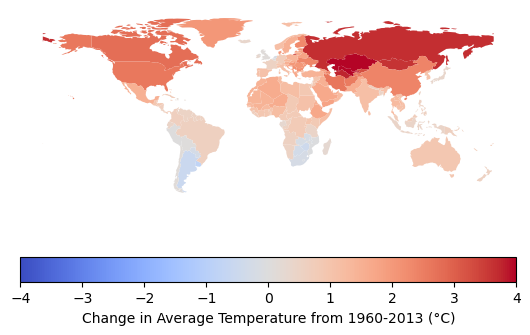

In [ ]:
fig, ax= plt.subplots(1,1)
deltaTempPlot = world.plot(column="delta_temp",
           ax=ax,
           legend=True,
           cmap="coolwarm",
           legend_kwds={"label":"Change in Average Temperature from 1960-2013 (°C)",
                        "orientation":"horizontal"},
            vmin=-4,
            vmax=4)
deltaTempPlot.set_axis_off()

### We see in the plot that essentially every country in the world has increased in temperature over the last 50 years. That being said, the magnitude in which the temperature changed is quite vast. There could be many different reasons for this, but my goal for this research project is to determine whether there is any correlation between a country's change in temperature and their individual CO2 emissions.